

# Movie Industry Data Analysis Project Group 1

This notebook analyzes movie data to answer key business questions for a new movie studio.
## Business Problem

Our company is planning to enter the film industry and launch a new movie studio. However, with no prior experience in movie production, we need to conduct thorough data analysis to guide our decisions. 

We aim to answer the following business questions:

1️⃣ What genres tend to perform best at the box office?  
2️⃣ Do critic ratings predict box office success?  
3️⃣ How do production budgets correlate with box office revenue?  
  

By answering these, we aim to make data-driven decisions on genre selection, budget allocation, and release scheduling.


## Table of Contents

- [1. Data Loading](#Data-Loading)
- [2. Data Cleaning](#Data-Cleaning)
- [3. Merging Datasets](#Merging-Datasets)
- [4. Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [5. Business Recommendations](#Business-Recommendations)


## 1. Data Loading

We load all required datasets into pandas dataframes from both SQLite database and CSV/TSV files. These contain IMDB data, budget data, box office revenues, and Rotten Tomatoes info.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import pandas as pd
import re

# Load IMDB database tables
conn = sqlite3.connect("im.db")
df_basics = pd.read_sql_query("SELECT * FROM movie_basics", conn)
df_ratings = pd.read_sql_query("SELECT * FROM movie_ratings", conn)

# Load external CSV & TSV files
df_bom = pd.read_csv("bom.movie_gross.csv")
df_budgets = pd.read_csv("tn.movie_budgets.csv")
df_rt_info = pd.read_csv("rt.movie_info.tsv", sep="\t", encoding="latin1")


## 2. Data Cleaning

Each dataset has different formats, missing values, and currency strings. We'll clean them one by one to prepare for merging.

### Clean IMDB movie_basics

We clean movie_basics by:

- Converting year and runtime to numeric (handle non-numeric values).
- Replacing missing genres with 'Unknown'.
- Creating a lowercase title field for future merging across datasets.


In [2]:

df_basics['start_year'] = pd.to_numeric(df_basics['start_year'], errors='coerce')
df_basics['runtime_minutes'] = pd.to_numeric(df_basics['runtime_minutes'], errors='coerce')
df_basics['genres'] = df_basics['genres'].replace('\\N', pd.NA).fillna('Unknown')
df_basics['clean_title'] = df_basics['primary_title'].str.lower().str.strip()


### Clean IMDB movie_ratings

We convert ratings & vote counts to numeric and filter out movies with very few votes (under 50) to ensure we're using stable ratings.


In [3]:

df_ratings['averagerating'] = pd.to_numeric(df_ratings['averagerating'], errors='coerce')
df_ratings['numvotes'] = pd.to_numeric(df_ratings['numvotes'], errors='coerce')
df_ratings = df_ratings[df_ratings['numvotes'] >= 50]


### Clean BOM movie_gross

We convert the revenue columns to numeric and clean titles for merging.


In [4]:

df_bom['domestic_gross'] = pd.to_numeric(df_bom['domestic_gross'], errors='coerce')
df_bom['foreign_gross'] = pd.to_numeric(df_bom['foreign_gross'], errors='coerce')
df_bom['clean_title'] = df_bom['title'].str.lower().str.strip()

### Clean TN movie_budgets

We remove currency symbols and commas from budget fields, convert dates to datetime format, and extract release years.


In [5]:

# Safely clean currency columns by removing $ and , and converting to float to avoid overflow errors
for col in ['production_budget', 'domestic_gross', 'worldwide_gross']:
    df_budgets[col] = (
        df_budgets[col]
        .replace('[\$,]', '', regex=True)  # remove currency symbols and commas
        .replace('', '0')  # in case empty strings remain, replace with 0
        .astype(float)  # convert safely to float to handle large numbers
    )

# Convert release_date column to pandas datetime
df_budgets['release_date'] = pd.to_datetime(df_budgets['release_date'], errors='coerce')

# Extract release year and release month for further analysis
df_budgets['release_year'] = df_budgets['release_date'].dt.year
df_budgets['release_month'] = df_budgets['release_date'].dt.month

# Create clean_title column for safe merging
df_budgets['clean_title'] = df_budgets['movie'].str.lower().str.strip()


<>:5: SyntaxWarning: invalid escape sequence '\$'
<>:5: SyntaxWarning: invalid escape sequence '\$'
/var/folders/ht/zbr8w6793p5bxcm924rzym5c0000gn/T/ipykernel_7718/2071766459.py:5: SyntaxWarning: invalid escape sequence '\$'
  .replace('[\$,]', '', regex=True)  # remove currency symbols and commas


### Clean Rotten Tomatoes movie_info

We parse dates, convert box office strings to numeric, and create a clean_title for joining (here we use ID for simplicity).


In [6]:

for col in ['production_budget', 'domestic_gross', 'worldwide_gross']:
    df_budgets[col] = (
        df_budgets[col]
        .replace(r'[\$,]', '', regex=True)
        .replace('', np.nan)  # Replace empty strings with NaN
    )
    df_budgets[col] = pd.to_numeric(df_budgets[col], errors='coerce')  # Safe conversion

## 3. Merging Datasets

We merge all cleaned datasets into one unified dataframe using clean_title or movie_id.

In [7]:

df_merged = df_basics.merge(df_ratings, on='movie_id', how='inner')
df_merged = df_merged.merge(df_bom[['clean_title', 'domestic_gross', 'foreign_gross']], on='clean_title', how='left')
df_merged = df_merged.merge(df_budgets[['clean_title', 'production_budget', 'worldwide_gross']], on='clean_title', how='left', suffixes=('', '_tn'))


## 4. Exploratory Data Analysis

### Which genres tend to perform best at the box office?

Since many movies have multiple genres combined (e.g. "Action,Adventure,Sci-Fi"), we first split them into individual genres before aggregation. This gives a more accurate genre-level comparison.


<Axes: title={'center': 'Average Worldwide Gross by Genre'}, ylabel='genres'>

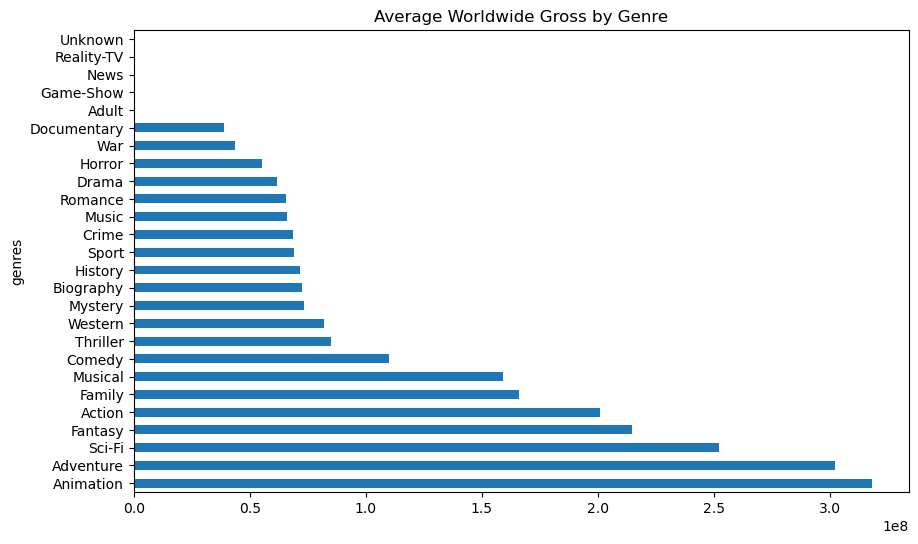

In [8]:

# Split multi-genre strings and explode into separate rows
df_exploded = df_merged.assign(genres=df_merged['genres'].str.split(',')).explode('genres')

# Group by individual genre and calculate average worldwide gross
genre_gross = df_exploded.groupby('genres')['worldwide_gross'].mean().sort_values(ascending=False)

# Plot clean bar chart
genre_gross.plot(kind='barh', figsize=(10,6), title='Average Worldwide Gross by Genre')



We now observe that genres like **Adventure, Animation, Fantasy and Sci-Fi** consistently generate higher worldwide gross revenues, indicating that these genres appeal to a global audience.


### Do critic ratings predict box office success?

We analyze the correlation between IMDB average ratings and worldwide revenue using scatterplots and correlation coefficients.


Text(0.5, 1.0, 'IMDB Rating vs Worldwide Gross')

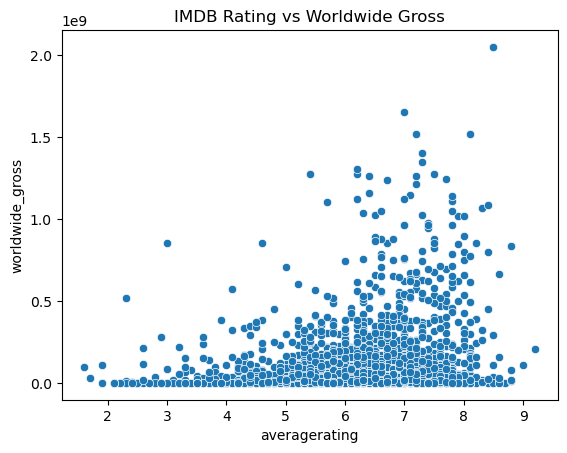

In [9]:

import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x='averagerating', y='worldwide_gross', data=df_merged)
plt.title("IMDB Rating vs Worldwide Gross")


In [10]:

correlation = df_merged['averagerating'].corr(df_merged['worldwide_gross'])
print("Correlation between rating and worldwide gross:", correlation)


Correlation between rating and worldwide gross: 0.22493112209243607



We find only a **weak but positive correlation** between IMDB ratings and revenue. While critically acclaimed films can perform well, high ratings alone don't guarantee high box office returns.


### How does production budget correlate with box office revenue?

We examine whether investing higher budgets is associated with greater financial success.


Text(0.5, 1.0, 'Production Budget vs Worldwide Gross')

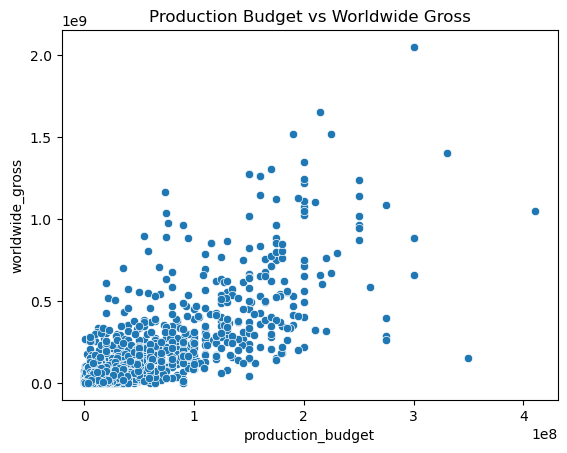

In [11]:

sns.scatterplot(x='production_budget', y='worldwide_gross', data=df_merged)
plt.title("Production Budget vs Worldwide Gross")


In [12]:

budget_correlation = df_merged['production_budget'].corr(df_merged['worldwide_gross'])
print("Correlation between budget and worldwide gross:", budget_correlation)


Correlation between budget and worldwide gross: 0.7805562786271399



There is a **strong positive correlation** between production budget and worldwide gross. Generally, movies with larger budgets tend to achieve higher revenue potential, though financial risks also rise.



### Does release timing affect box office revenue?

Here we analyze whether release month impacts movie revenue. Certain months (summer blockbusters, holiday seasons) may lead to stronger performance due to audience behavior and competition.


In [13]:

# Ensure release_date is in datetime format
df_budgets['release_date'] = pd.to_datetime(df_budgets['release_date'], errors='coerce')

# Extract release month
df_budgets['release_month'] = df_budgets['release_date'].dt.month

# Merge release month into merged dataset
df_merged = df_merged.merge(df_budgets[['clean_title', 'release_month']], on='clean_title', how='left')


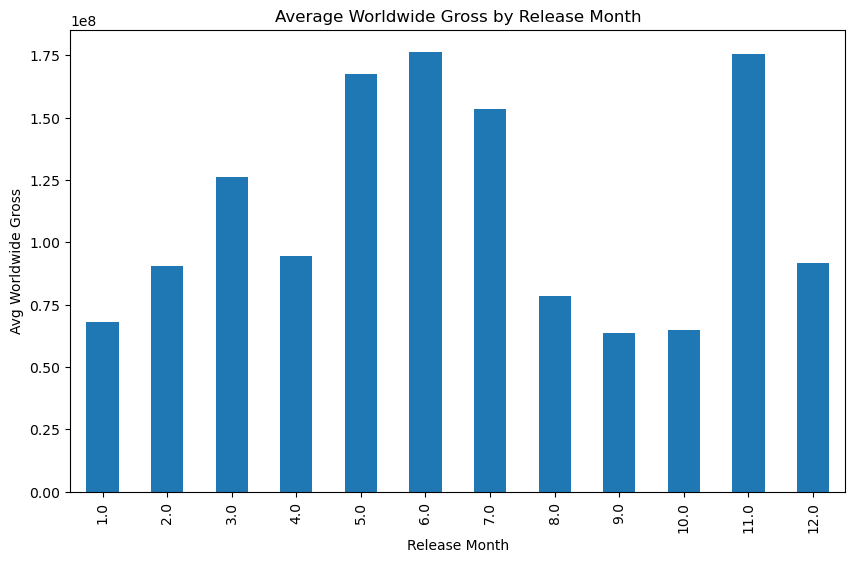

In [14]:

import matplotlib.pyplot as plt
import seaborn as sns

# Plot average revenue by release month
month_revenue = df_merged.groupby('release_month')['worldwide_gross'].mean()
month_revenue.plot(kind='bar', figsize=(10,6), title='Average Worldwide Gross by Release Month')
plt.xlabel("Release Month")
plt.ylabel("Avg Worldwide Gross")
plt.show()


In [15]:
# Genre frequency
print("Genre Counts:")
print(df_exploded['genres'].value_counts())

# Release month frequency
print("\nRelease Month Counts:")
print(df_merged['release_month'].value_counts().sort_index())


Genre Counts:
genres
Drama          17287
Comedy         10505
Thriller        5276
Documentary     5259
Action          4612
Horror          4452
Romance         4198
Crime           3086
Adventure       2347
Mystery         1887
Biography       1785
Family          1750
Sci-Fi          1382
History         1271
Fantasy         1271
Animation       1067
Music            912
Sport            635
War              491
Musical          333
News             178
Western          148
Unknown           73
Reality-TV         1
Game-Show          1
Adult              1
Name: count, dtype: int64

Release Month Counts:
release_month
1.0     151
2.0     190
3.0     229
4.0     233
5.0     176
6.0     225
7.0     193
8.0     220
9.0     214
10.0    254
11.0    213
12.0    329
Name: count, dtype: int64
